# Clone du projet "SHAP: Understanding the Functioning of an ML-based (XGBoost) Bipolar Disorder Crisis Predictor Model"
### Nouvelles données utilisées : Road Accident Survival Dataset
### Réalisé par : Moqim Ghizlan et Thibaut JUILLARD


In this tutorial, you will learn how to apply eXplainable methods to machine learning models for tabular data. The goal is to understand how the models operate and what are the main criterias used for the decision making. Since we are working with tabular data, we will consider a  very familiar use-case.

In particular, we are going to focus on a specific explanation model called SHapley Additive exPlanations, SHAP (https://arxiv.org/pdf/1705.07874.pdf). It will be implemented using the framework developed by Lundberg in https://github.com/slundberg/shap.

Based on game theory, SHAP considers each feature as a "player" in a cooperative game. In a nutshell, what SHAP does is quantifying the contribution that each feature brings to the prediction given by the model.

In this notebook we will learn how the SHAP values are computed mathematically with a simple example and then focus on a critical aplication of Machine Learning models: Bipolar Disorder Crisis Prediction.



### Shapley values: Definition

One of the main contribution of SHAP is to consider the explanation as a model itself. The explanation model is a linear function of a binary variable:


\begin{equation}
g(z') = \phi_0 + \sum_{i=1}^{M}\phi_i z'_i
\end{equation}

where $z' \in \{0,1\}^M $, M is the number of simplified features, and $\phi_i \; in \; \mathbb{R}$. *z'* represents the simplified features vector, $\phi_i $ is the feature attribution for feature *i*.

\begin{equation}
\phi_i = \sum_{S \subseteq F \ \{i\}} \frac{\mid S\mid! (\mid F\mid - \mid S\mid - 1)!}{\mid F\mid !} [f_{S \bigcup \{i\}}(x_{S \bigcup \{i\}}) - f_S(x_S)]
\end{equation}

where $f$ represents the model function, and $S \subseteq F $, where $F$ is the set of all features and $S$ a subset of $F$. Shap values are a weighted average of all possible difference subsets. $\mid S \mid$ represents the number of elements of subset $S$.

The Shapley value is a method that satisfies four properties: Efficiency, Symmetry, Dummy and Additivity.

Efficiency refers to the fact that the feature contribution must add up to the difference of the prediction for a given $x$ and the average.

The Symmetry property obligates the contributions of to feature values to be the same if they contribute identically to all possible coalitions.

Additivity: For bagging ensemble algorithms (i.e., bagging methods consist on fitting different models on the dataset and then average the outcome of each model), it means that the shap value can computed using the individual shap values for each independant model of the bagging algorithm.

Finally, the Dummy property is defined as the property of the shapley value that assures that the contribution of a feature that do not change the predicted value of the coalition of feature values that it has been added to
is equal to zero.

To be able to understand the Shap values, what they mean and how they are computed, we are going to consider a simple example: Let's imagine we have a model (any machine learning model) that outputs the  probability of not paying your credit given a set of 3 features (for instance age, localization and income).

SHAP values consider each combiniation or coalition of players (i.e., features) to determine the importance of a single player (i.e., features). As we are considering a simple set of 3 features, the number of different models with different sets of features we have to build are $2^3$. It is important to remark that all models are constructed with the same hyperparameters.



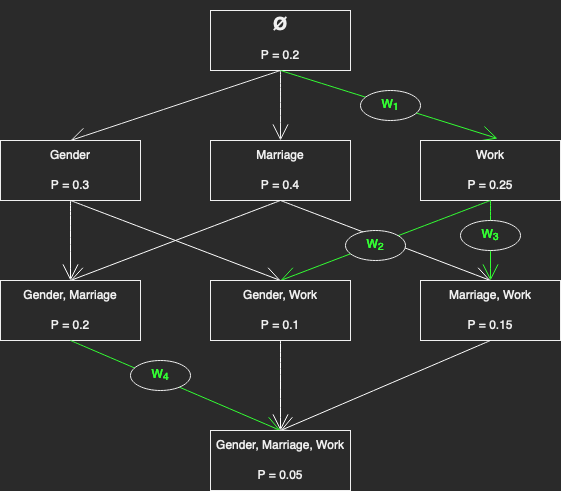

The output of the empty set ($\phi_0)$ is the number of total positive class cases over the number of data points. In this simple example the number of positive classes is 0.2. Now let's take a look on how the prediction of the model changes when we add the feature income for a single datapoint $x$. The considered set is the empty set.

$S_0 = \{\emptyset\}$

$f_{S_0}(x_{S_0}) = 0.2$

$f_{S_0 \bigcup \{work\}}(x_{S_0 \bigcup \{work\}}) = 0.25$

Now we consider all subsets of $F$ that that do not contain the feature *income*  ($S \subseteq F \ \{i\}$) and check the difference on the model's output when we consider the same subset, but adding the feature income.

$S_1 = \{gender\}$

$f_{S_1}(x_{S_1}) = 0.3$

$f_{S_1 \bigcup \{work\}}(x_{S_1 \bigcup \{work\}}) = 0.25$


$S_2 = \{Marriage\}$

$f_{S_2}(x_{S_2}) = 0.4$

$f_{S_2 \bigcup \{work\}}(x_{S_2 \bigcup \{work\}}) = 0.15$

$S_3 = \{Marriage, gender\}$

$f_{S_3}(x_{S_3}) = 0.2$

$f_{S_3 \bigcup \{work\}}(x_{S_3 \bigcup \{work\}}) = 0.05$

Once we find all model outputs for all different susbsets, we compute a weighted average of the model's output, with and without the feature.

The criteria the weights have to meet are the following:
  1. $\sum_{i} w_i = 1$
  2. $w_1 = w_2 + w_3 = w_4$

As mentioned above we are just considering the impact of the feature *income* in the model's outcome. To obtain the Shap values for the rest of the features we repeat the same strategy.

Let's apply the formula to obtain the Shap values $\phi_i$. Since we have four subsets that do not contain the feature *income*, we are going to feature attribution for each subset.

Feature attribution for $S_0$:

\begin{equation}
\frac{\mid S_0\mid! (\mid F\mid - \mid S_0\mid - 1)!}{\mid F\mid !} [f_{S_0 \bigcup \{i\}}(x_{S_0 \bigcup \{i\}}) - f_{S_0}(x_{S_0})] = \frac{0! (3 - 0 - 1)!}{3!} [0.25-0.2] = \frac{1}{3}0.05
\end{equation}

Now we repeat the same computation for $S_1$ , $S_2$, and $S_3$

For $S_1$: $\frac{1}{6}(-0.05)$

For $S_2$: $\frac{1}{6}(-0.25)$

For $S_3$: $\frac{1}{3}(-0.15)$

$\phi_i = \frac{1}{3}0.05 + \frac{1}{6}(-0.05) + \frac{1}{6}(-0.25) + \frac{1}{3}(-0.15) = -\frac{1}{6}0.5$

## Use Case: Road Accident Survival Dataset

Le dataset utilisé regroupe diverses informations sur des accidents de la route et sur la survie ou non du conducteur. Pour utiliser ce dataset, nous utilisons Kaggle (https://www.kaggle.com/datasets/himelsarder/road-accident-survival-dataset)

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
################## Downdload Kaggle Dataset ########################

# Télécharger kaggle.json depuis l'ordinateur (API KAGGLE)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thibautjuill","key":"25838b2a450cbd48ea7c6b338c47ee34"}'}

In [ ]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d himelsarder/road-accident-survival-dataset
!unzip road-accident-survival-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/himelsarder/road-accident-survival-dataset
License(s): CC0-1.0
  0% 0.00/1.19k [00:00<?, ?B/s]
100% 1.19k/1.19k [00:00<00:00, 3.47MB/s]
Archive:  road-accident-survival-dataset.zip
  inflating: accident.csv            


### Setting the Environment

In [ ]:
import sys
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np

#pd.set_option("max_rows", 500)
#pd.set_option("max_columns", 500)


import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=16)

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import model_selection

In [ ]:
import pandas as pd

df = pd.read_csv("accident.csv")
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


In [ ]:
target = df['Survived']
features = df.drop('Survived',axis=1)

In [ ]:
features

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used
0,56,Female,27.0,No,No
1,69,Female,46.0,No,Yes
2,46,Male,46.0,Yes,Yes
3,32,Male,117.0,No,Yes
4,60,Female,40.0,Yes,Yes
...,...,...,...,...,...
195,69,Female,111.0,No,Yes
196,30,Female,51.0,No,Yes
197,58,Male,110.0,No,Yes
198,20,Male,103.0,No,Yes


In [ ]:
#####Transform col
def transform_col(df: pd.DataFrame):
  df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="Male" else 0)
  df["Helmet_Used"] = df["Helmet_Used"].apply(lambda x: 1 if x=="Yes" else 0)
  df["Seatbelt_Used"] = df["Seatbelt_Used"].apply(lambda x: 1 if x=="Yes" else 0)

  return df

In [ ]:
features = transform_col(features)

In [ ]:
features.columns

Index(['Age', 'Gender', 'Speed_of_Impact', 'Helmet_Used', 'Seatbelt_Used'], dtype='object')

In [ ]:
features.sample(n=3)

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used
152,32,0,86.0,0,0
136,44,0,31.0,1,1
0,56,0,27.0,0,0


**Target Distribution**


- Survived: **1**

- Not survived: **0**

<Axes: ylabel='Survived'>

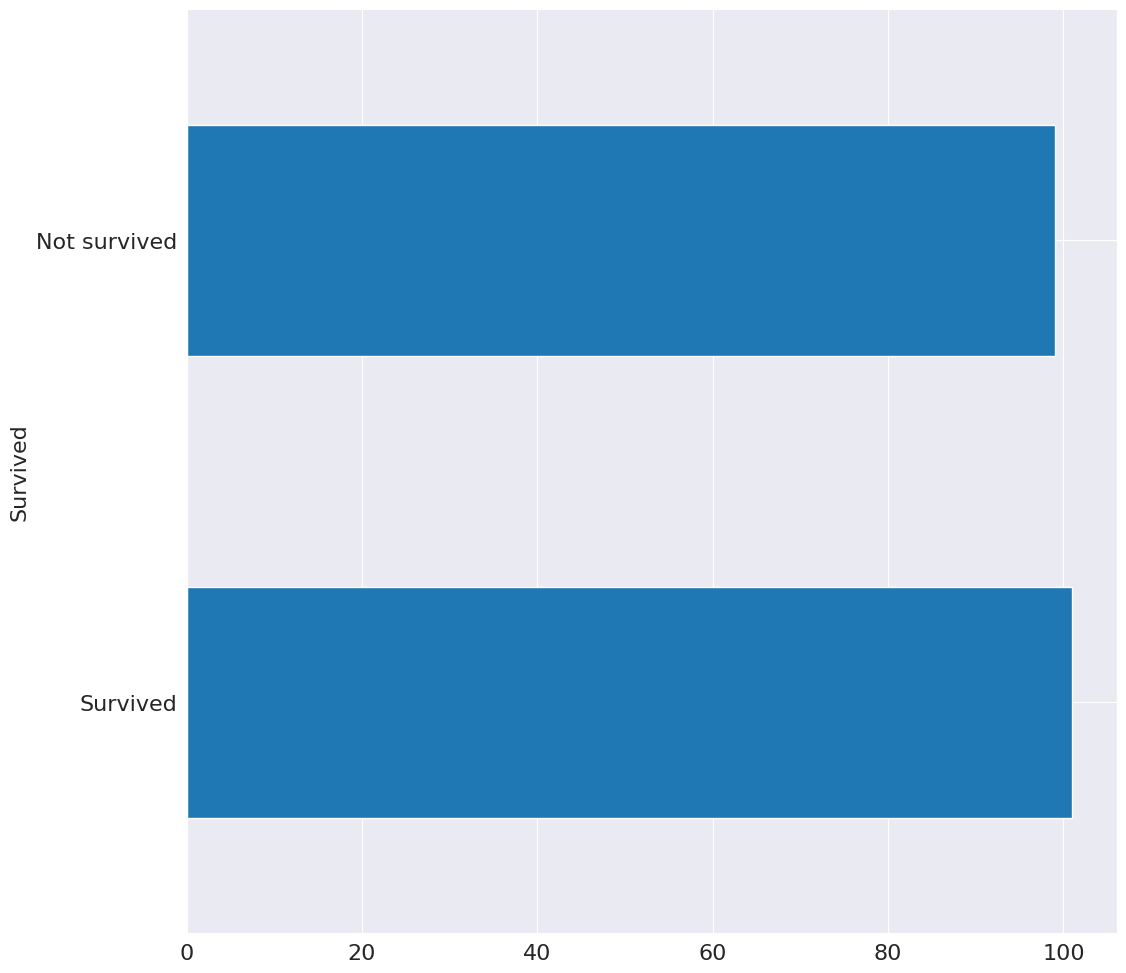

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,12))
counter = target.value_counts()
counter.rename(index={1.0: "Survived",
                      0.0: "Not survived"},
               inplace=True
              )
ax.set_xlabel("# Cases", size=16)
counter.plot(kind="barh", ax=ax)


In [ ]:
x, y = features, target

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=80,
                                                                    stratify=target)

In [ ]:
x_train

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used
198,20,1,103.0,0,1
120,58,1,71.0,1,1
187,47,0,115.0,0,1
148,56,0,82.0,0,1
8,36,0,83.0,1,0
...,...,...,...,...,...
136,44,0,31.0,1,1
160,69,0,97.0,1,1
186,37,0,77.0,0,0
26,29,1,56.0,0,1


In [ ]:
counter

,count
Survived,
Survived,101
Not survived,99


In [ ]:
proportion_class = counter["Survived"]/counter["Not survived"]

params_xgb = {
    "n_estimators": 200,
    "max_depth": 8,
    "learning_rate": 0.05,
    "scale_pos_weight": proportion_class
}
xgb = XGBClassifier(**params_xgb, use_label_encoder=True)

In [ ]:
# Erreur si on affiche le resultat
xgb.fit(x_train, y_train);

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

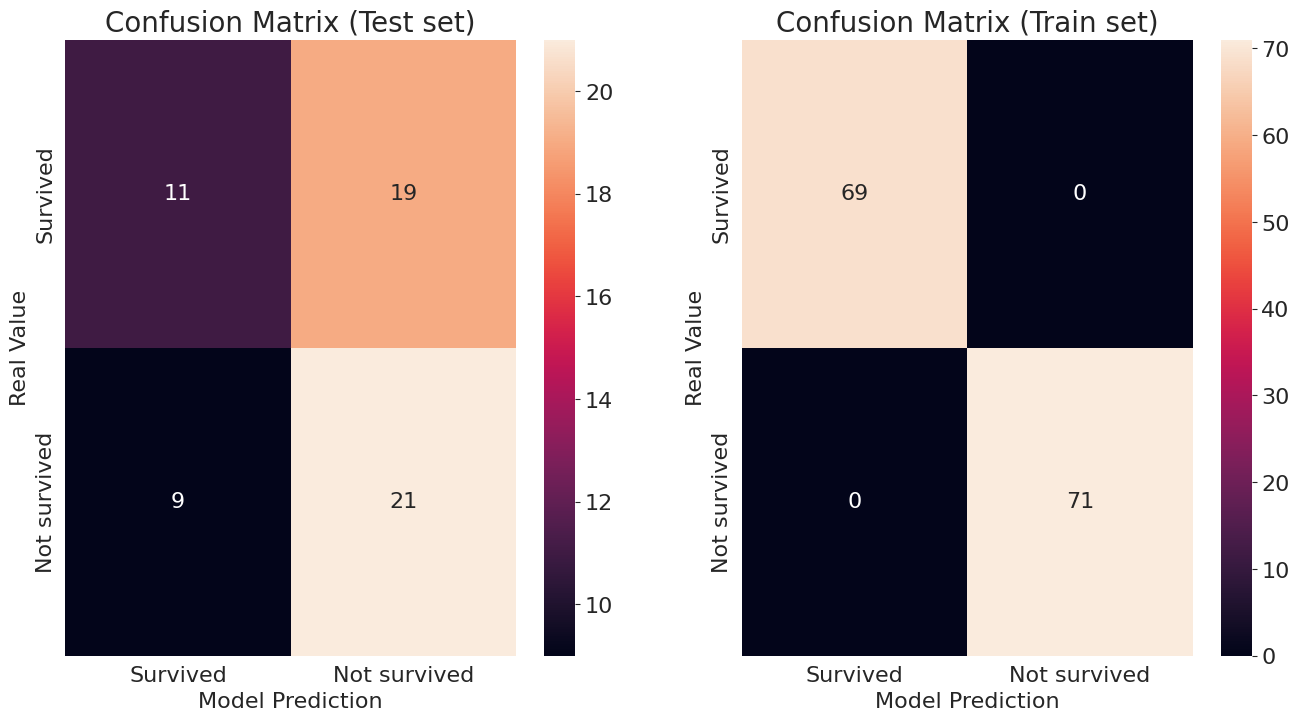

In [ ]:
y_hat = xgb.predict(x_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=xgb.predict(x_train), y_true=y_train)
names_df = [
    "Survived",
    "Not survived"
]
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

## SHAP Values

Now we are going to use what we learnt from the SHAP values to understand how our model works. We use the framework developed by Lundberg et al. https://github.com/slundberg/shap

In [ ]:
#Run if shap not installed
! pip install shap

In [ ]:
import shap

**We are going to explain the xgboost model. Since the model developed previously is a tree based we are going to use Tree explainer, a fast implementation to compute Shap values when models are tree based**

In [ ]:
explainer = shap.TreeExplainer(xgb, x, model_output = "raw")
shap_values = explainer.shap_values(x)

**Local interpretability: How do we interpret the SHAP force plot?**


The value we observe in bold is the natural logarithm of the odd ratio $ln(\frac{P(Y=1)}{1-P(Y=1)})$. The base value is the odd ratio if we just consider the number of positive cases over the total of instances. The Shapley values can be understood as forces that push the output of the model. Forces of Shapley values in blue represent the features that increase the probability of default, while red values represent the features that are incrementing the probability of having a bipolar disease.

A force plot allows us to study a concrete case in order to give a reason for diagnosing a potential bipolar disease.

In [ ]:
shap.initjs()
patient_index = 11
shap.force_plot(explainer.expected_value, shap_values[patient_index,:], x.iloc[patient_index,:])

In [ ]:
print(y.replace(diagnosis_map).iloc[patient_index])

Not survived


In [ ]:
patient_index = 2

# Patient real target value
diagnosis_map = {1.0: "Survived",
                0.0: "Not survived"}
print("-------Patient Real Diagnosis------")

print(y.replace(diagnosis_map).iloc[patient_index])
print("-------Patient Predicted Diagnosis------")
pred_class = xgb.predict(x.loc[patient_index:patient_index, :])[0]
if pred_class==0.0:
    pred_diagnosis = diagnosis_map[0.0]
    p1 = xgb.predict_proba(x.loc[patient_index:patient_index, :])[0][0]
    p1_round = round(p1,3)
else:
    pred_diagnosis = diagnosis_map[1.0]
    p1 = clf_rf.predict_proba(x.loc[patient_index:patient_index, :])[0][1]
    p1_round = round(p1,3)
print(f'Probability of being diagnosed with a {pred_diagnosis} \n{p1_round}')


-------Patient Real Diagnosis------
Not survived
-------Patient Predicted Diagnosis------
Probability of being diagnosed with a Not survived 
0.7689999938011169


**Global interpretability: SHAP Summary plot.**

The SHAP summary plot allows us to understand the model by ranking the features from the most relevant to the least important ones. Each datapoint represents a different person. In this concrete use case, the most relevant feature are: the variation of the activity mesasurements obtained of the actigraph watch, the Montgomery Asberg Depression Rating Scale at the moment the actigraph was stopped. High values of these features impact negatively in the output of the model (the probability of having a bipolar disease increases).

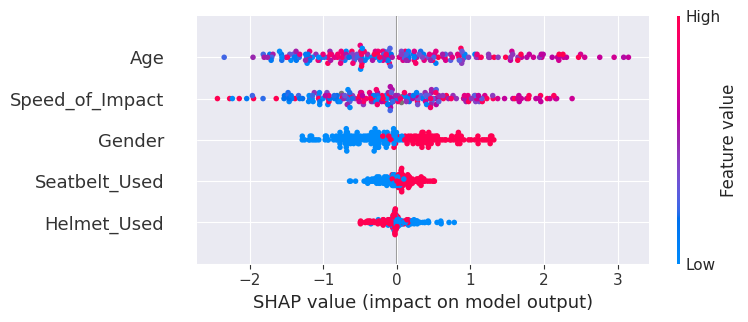

In [ ]:
shap.summary_plot(shap_values, x, show=False)

plt.savefig("shap_summary_plot.png", bbox_inches="tight")

# Rapport et Analyse Finale

## Objectif du Projet


L'objectif de ce projet est d'explorer l'application des méthodes explicables aux modèles d'apprentissage automatique pour les données tabulaires. Plus précisément, nous utilisons les SHapley Additive exPlanations (SHAP) pour comprendre le fonctionnement d'un modèle de prédiction de la survie des conducteurs impliqués dans des accidents de la route. SHAP permet d'attribuer une importance à chaque variable du modèle, facilitant ainsi l'interprétation des décisions prises par l'algorithme.

## Analyse des Résultats

L'analyse des valeurs SHAP issues de notre modèle met en évidence plusieurs tendances clés. En observant les visualisations fournies :

L'âge du conducteur semble avoir une influence notable sur les prédictions, les valeurs SHAP montrant un impact différencié en fonction de l'âge.

La vitesse d'impact est un facteur majeur, les valeurs élevées étant associées à un risque accru.

L'utilisation de la ceinture de sécurité et du casque ont un impact protecteur significatif sur la survie des conducteurs.

Le genre du conducteur semble également jouer un rôle, bien que son interprétation puisse nécessiter une analyse plus approfondie.

Ces résultats soulignent l'importance des mesures de sécurité routière et pourraient être utilisés pour affiner les stratégies de prévention des accidents.

## Points Positifs et Limites

**Points Positifs :**

SHAP offre une interprétation claire et quantitative de l'impact des variables sur les prédictions du modèle.

La méthode est basée sur une approche rigoureuse issue de la théorie des jeux, garantissant une répartition équitable des contributions des variables.

Les visualisations facilitent l'analyse et la communication des résultats à des non-experts.

**Limites :**

Le calcul des valeurs SHAP peut être coûteux en temps de calcul, surtout pour des modèles complexes. (Nous avons essayer au début avec un jeux de donnée de 250 000 lignes mais cela prenait beaucoup trop de temps)

L'interprétation des interactions entre variables peut être difficile, notamment lorsque des corrélations fortes existent entre plusieurs facteurs.

La méthode repose sur un modèle préalablement entrainé et ne garantit pas que ce dernier soit dépourvu de biais.

## Conclusion

Ce projet a permis d'explorer l'application des SHAP values pour interpréter un modèle de prédiction de la survie en cas d'accident de la route. Nous avons identifié les principaux facteurs influençant la prédiction du modèle, notamment la vitesse d'impact, l'âge du conducteur, et l'utilisation d'équipements de protection. Ces informations peuvent être utilisées pour améliorer les recommandations en matière de sécurité routière et orienter les actions de prévention.

Cette approche constitue un outil précieux pour rendre l'apprentissage automatique plus transparent et interprétable.